In [17]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
from tqdm import tqdm
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [18]:
import matplotlib
def rgba(i, N):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    cmap = plt.cm.plasma
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

# Full $V_\mathrm{trap}^{\mathrm{park}}$ sweep for $N=150$

In [24]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Avalanches"
sub_dirs = glob(os.path.join(save_path, "*Fast_Trap_Sweep*"))
pprint([os.path.split(sub_dirs[k])[1] for k in range(len(sub_dirs))])

['170804_160323_M018V6_Fast_Trap_Sweep_resonator_sweep',
 '170804_162256_M018V6_Fast_Trap_Sweep_resonator_sweep',
 '170804_164426_M018V6_Fast_Trap_Sweep_resonator_sweep',
 '170804_174256_M018V6_Fast_Trap_Sweep_resonator_sweep']


1it [00:11, 11.09s/it]


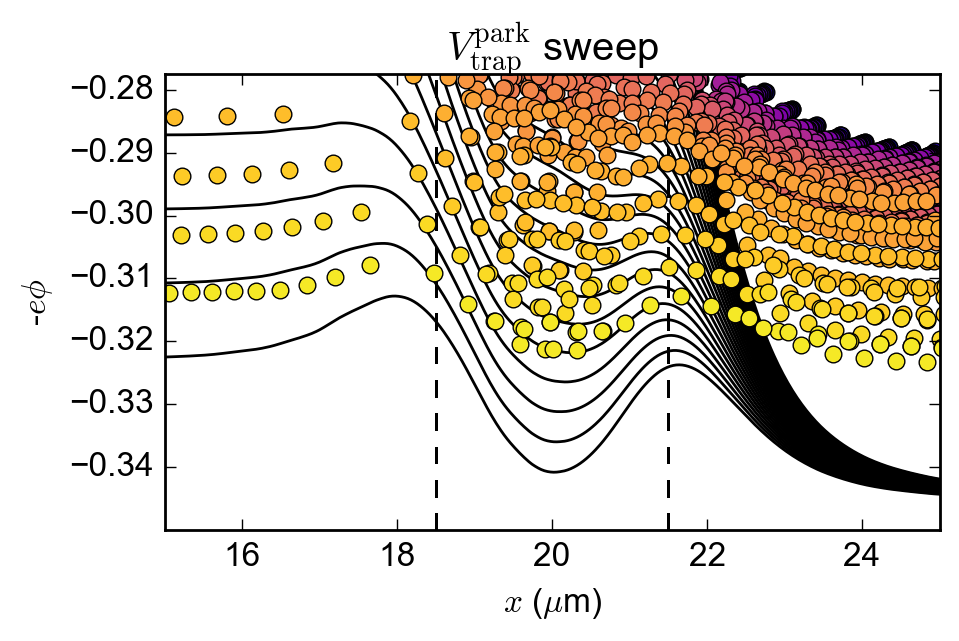

In [23]:
fig=plt.figure(figsize=(5.,10))
common.configure_axes(12)

Vrg_parks = list()
num_unbounded = list()
num_electrons = list()


for l, sub_dir in tqdm(enumerate(sub_dirs[-1:])):
    Vtraps = list()
    num_total_electrons = list()
    e_density = list()
    xis_resonator = list()
    mus, xis, cut, x_cut = list(), list(), list(), list()
    trap_domain_x = (18.5E-6, 21.5E-6)

    converged, energy, num_trapped_electrons = list(), list(), list()
    with h5py.File(os.path.join(save_path, sub_dir, "Results.h5"), "r") as f:
#         print("Directory: %s" % os.path.split(sub_dir)[1])
        k = 0

        resVs, trapVs, resgVs, trapgVs = f["Vres"][()], f["Vtrap"][()], f["Vrg"][()], f["Vtg"][()]
        Vtraps.append(np.max(trapVs))
        
        for i, step in enumerate(f.keys()):
            if "step" in step:
                potential = resVs[k] * f["resonator"][()] + trapVs[k] * f["trap"][()] + resgVs[k] * f["res_guard"][()] \
                            + trapgVs[k] * f["trap_guard"][()]
                yidx = common.find_nearest(f["ypoints"][()][:,0], 0.0)
                cut.append(potential[yidx,:])
                x_cut.append(f["xpoints"][()][yidx,:])
                
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/final_energy"][()])
                mus.append(f[step+"/mu"][()])
                xis.append(xi)
                xis_resonator.append(xi[xi > 21.5E-6])
                num_unbounded.append(len(xi[xi < 17.5E-6]))

                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)
                if k == 0:
                    num_total_electrons.append(len(xi))
                    xi_resonator = xi[xi > 21.5E-6]
                    yi_resonator = yi[xi > 21.5E-6]
                    e_density.append(anneal.get_electron_density_by_position(anneal.xy2r(xi_resonator, yi_resonator)))
                    
                k += 1
                
                num_trapped_electrons.append(np.sum(np.logical_and(xi < trap_domain_x[1], xi > trap_domain_x[0])))
        
        num_electrons.append(num_trapped_electrons)

    xis = np.array(xis)
    xis_resonator = np.array(xis_resonator)
    mus = np.array(mus)
    cut = np.array(cut)
    x_cut = np.array(x_cut)
    
    separated, max_res_electron_energy, barrier_heights = list(), list(), list()
    selection = np.arange(np.shape(xis)[0])[::4] 
    Vrg_parks.append(np.max(resgVs))

#     plt.figure(figsize=(5.,10))
    plt.subplot(311)
    for i, idx in enumerate(selection):
#         if idx==selection[-1]:
        plt.plot(xis[idx,:]*1E6, mus[idx,:], 'o', color=rgba(i, len(selection)))
        ymin, ymax = -0.35, -np.max(trapVs)*0.50
        plt.vlines([trap_domain_x[0]*1E6, trap_domain_x[1]*1E6], ymin, ymax, linestyles='--', color='k')
        plt.plot(x_cut[idx,:]*1E6, cut[idx,:], color='k')
        plt.ylim(ymin, ymax)
        plt.xlim(15, 25)
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("-$e\phi$")
        plt.title("$V_\mathrm{trap}^\mathrm{park}$ sweep")

        closest_resonator_electron = xis_resonator[idx][common.find_nearest(xis_resonator[idx], 21.5E-6)]
        closest_resonator_electron_mu = mus[idx, common.find_nearest(xis[idx,:], closest_resonator_electron)]
        x_bar_min = common.find_nearest(x_cut[idx,:], 21E-6)
        x_bar_max = common.find_nearest(x_cut[idx,:], 22E-6)
        x_trap_min = common.find_nearest(x_cut[idx,:], trap_domain_x[0])
        x_trap_max = common.find_nearest(x_cut[idx,:], trap_domain_x[1])
        barrier_heights.append(np.max(cut[idx,x_bar_min:x_bar_max]))
        trap_level = np.min(cut[idx, x_trap_min:x_trap_max])
    
        if i==selection[-1]:
            plt.hlines(closest_resonator_electron_mu, 15, 25, linestyles='--', color='red')
        separated.append(np.logical_and(barrier_heights[i]>closest_resonator_electron_mu, 
                                        barrier_heights[i]>trap_level))
        max_res_electron_energy.append(closest_resonator_electron_mu)

#     plt.subplot(312)
#     plt.plot(trapVs[selection], np.array(barrier_heights) - np.array(max_res_electron_energy), 
#              '-', color=rgba(l, len(sub_dirs)))
# #     plt.hlines(0.00, np.min(resgVs), np.max(resgVs), linestyles='--', color='r')
#     plt.xlabel("$V_\mathrm{trap}$")
#     plt.ylabel("$E_\mathrm{barrier}$ - $\mu_\mathrm{max, res}$")

#     plt.subplot(313)
#     plt.plot(trapVs[selection], np.array(max_res_electron_energy), '-', color=rgba(l, len(sub_dirs)))
#     plt.xlabel("$V_\mathrm{trap}$")
#     plt.ylabel("$\mu_\mathrm{max, res}$")
#     ymin, ymax = plt.ylim()
#     plt.vlines(rg_sep, ymin, ymax, linestyles='--', color='r' )
    #plt.ylim(-0.28, -0.265)
    
# common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

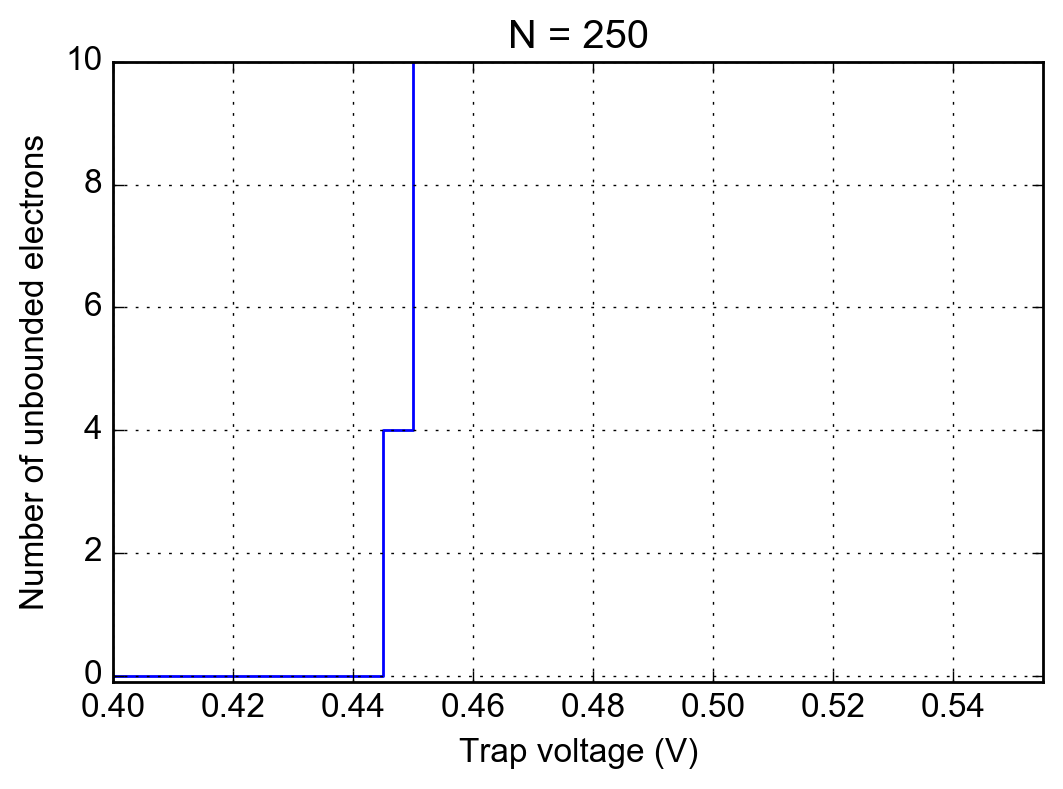

In [25]:
plt.figure()
plt.step(trapVs, num_unbounded)
plt.grid()
plt.ylim(-0.1, 10)
plt.xlim(0.4, np.max(trapVs))
plt.xlabel("Trap voltage (V)")
plt.ylabel("Number of unbounded electrons")
plt.title("N = %d"%(len(xi)))